# Sample use of the sun topic model 

In [11]:
import numpy as np
from sun_topicmodel import suntopic
import matplotlib.pyplot as plt
import pandas as pd

coeff_true: [ 0.37623932  0.96743045  1.59826729 -0.43503633 -1.06292707 -1.35712958
  0.57855717  0.54202354  1.28877997  1.8068061 ]


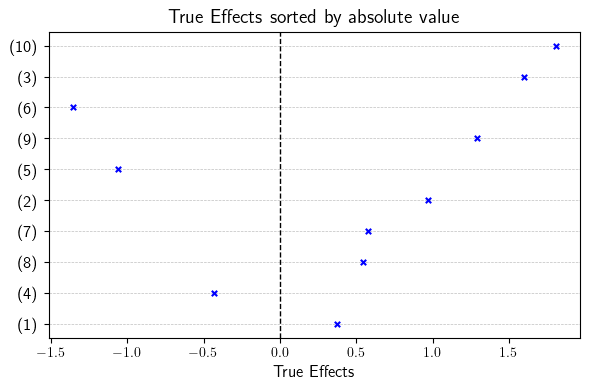

In [14]:
# Generate random data as the 'embeddings' for the 'documents' in the corpus
np.random.seed(2024)
n = 2000
m = 500
J = 10
W_t = np.random.rand(n, J)
H_t = np.random.rand(J, m)
X = np.dot(W_t, H_t) + np.random.rand(n, m) * 0.1
coef_true = np.random.normal(0, 1, J)
Y = np.dot(W_t, coef_true) + np.random.rand(n) * 0.1
print(f"coeff_true: {coef_true}")

sorted_indices = np.argsort(np.abs(coef_true))[::-1]
sorted_coef_true = coef_true[sorted_indices]

# Set font to Computer Modern
plt.rcParams["text.usetex"] = True

# Plot the parameters
fig, ax = plt.subplots(figsize=(6, 4))

for i, param in enumerate(sorted_coef_true):
    ax.axhline(i, color="gray", linestyle="--", linewidth=0.5, alpha=0.5)
    ax.scatter(param, i, marker="x", s=15, color="blue", zorder=10)


# Customize the plot
ax.axvline(0, color="black", linestyle="--", linewidth=1)  # Add a vertical line at x=0
ax.yaxis.tick_left()
ax.invert_yaxis()  # Flip the graph
ax.set_yticks(np.arange(len(sorted_coef_true)))
ax.set_yticklabels([f"({i+1})" for i in sorted_indices], fontsize=12)
ax.set_xlabel("True Effects", fontsize=12)
ax.set_title("True Effects sorted by absolute value", fontsize=14)

# Save or show the plot
plt.tight_layout()
plt.show()

In [15]:
# do train, estimation split
X_train = X[:1500, :]
X_est = X[1500:, :]
Y_train = Y[:1500]
Y_est = Y[1500:]

# Initialize and fit the model
model = suntopic(Y=Y_train, X=X_train, alpha=0.5, num_bases=3, random_state=2024)
model.fit()
model.summary()

Suntopic Model Summary
Number of topics:  3
Alpha:  0.5
Data shape:  (1500, 501)
Model:  <sun_topicmodel.snmf.SNMF object at 0x30a8e6950>
Random initialization state:  2024
Prediction coefficients:  [1.26416779 0.66074342 0.92747028]
In-sample MSE:  1.3218398950604096


In [16]:
# Initialize and fit the model
model = suntopic(Y=Y_train, X=X_train, alpha=0.1, num_bases=3, random_state=2024)
model.fit()
model.summary()

Suntopic Model Summary
Number of topics:  3
Alpha:  0.1
Data shape:  (1500, 501)
Model:  <sun_topicmodel.snmf.SNMF object at 0x109f72750>
Random initialization state:  2024
Prediction coefficients:  [1.71493726 0.86627354 1.24499589]
In-sample MSE:  0.9006438050718861


In [17]:
# Use cross validation for finding optimal hyperparameters: number of bases and alpha
model.hyperparam_cv(
    alpha_range=np.linspace(0.1, 0.9, 9),
    num_bases_range=np.arange(2, 10),
    cv_folds=5,
    random_state=2024,
)
model.cv_summary()

KeyboardInterrupt: 

In [ ]:
# Use parallelization to speed up the hyperparameter search
model.hyperparam_cv(
    alpha_range=np.linspace(0.1, 0.9, 9),
    num_bases_range=np.arange(2, 12),
    cv_folds=5,
    random_state=2024,
    parallel=True,
)
model.cv_summary()

In [ ]:
model.cv_mse_plot()

In [ ]:
# Initialize and fit the model with best hyperparameters
model = suntopic(Y=Y_train, X=X_train, alpha=0.4, num_bases=8, random_state=2024)
model.fit()
model.summary()

# Estimate AMCE 

In [ ]:
import statsmodels.api as sm

In [ ]:
Y_est_pred, W_est = model.predict(X_est, return_topics=True, random_state=2024)
print(f"{W_est.shape = }")

# Fit a linear regression model to the estimated topics
W_est = sm.add_constant(W_est)
model_est = sm.OLS(Y_est, W_est).fit()
print(model_est.summary())

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc


# Set font to Computer Modern
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
plt.rcParams["text.usetex"] = True

# Extract parameters and confidence intervals from the regression results
params = model_est.params[1:]
conf_int = model_est.conf_int()[1:]

# Plot the parameters
fig, ax = plt.subplots(figsize=(6, 4))

for i, (param, (lower, upper)) in enumerate(zip(params, conf_int)):
    # Add horizontal lines between rows
    ax.axhline(i, color="gray", linestyle="--", linewidth=0.5, alpha=0.5)

    if lower <= 0 & 0 <= upper:
        ax.plot(
            [lower, upper],
            [i, i],
            color="lightgray",
            linewidth=6,
            solid_capstyle="butt",
            alpha=0.7,
        )
        ax.scatter(param, i, marker="o", s=6, color="black", zorder=10)

    elif lower <= 0 & 0 >= upper:
        ax.plot(
            [lower, upper],
            [i, i],
            color="red",
            linewidth=6,
            solid_capstyle="butt",
            alpha=0.3,
        )
        ax.scatter(param, i, marker="o", s=6, color="black", zorder=10)

    else:
        ax.plot(
            [lower, upper],
            [i, i],
            color="green",
            linewidth=6,
            solid_capstyle="butt",
            alpha=0.3,
        )
        ax.scatter(param, i, marker="o", s=6, color="black", zorder=10)

# Customize the plot
ax.axvline(0, color="black", linestyle="--", linewidth=1)  # Add a vertical line at x=0
ax.yaxis.tick_left()
ax.invert_yaxis()  # Flip the graph
ax.set_yticks(np.arange(len(params)))
ax.set_yticklabels([f"({i+1})" for i in range(len(model_est.params) - 1)], fontsize=12)
ax.set_xlabel("Estimated Effects", fontsize=12)
# include lin break in the title
ax.set_title("Estimates of Topic Effects with 95\% Confidence Intervals", fontsize=14)


# Save or show the plot
plt.tight_layout()
# plt.savefig( str(data_dir) + '/LinWood_Causal_Effects_plot2.png',bbox_inches="tight", dpi=600)  # Save the plot as an image file
plt.show()